In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [17]:
train = pd.read_csv("train_without_error.csv")
test = pd.read_csv("test_without_error.csv")

In [18]:
train.shape, test.shape

((2869, 15), (1008, 14))

In [19]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [20]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [21]:
# 임대보증금 피처 전처리

train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

In [22]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [23]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [24]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
train_df.loc[train_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)
test_df.loc[test_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

In [25]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [26]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [27]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

<AxesSubplot:>

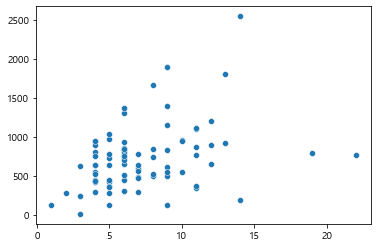

In [28]:
area_group = train_df.groupby("지역")["등록차량수"]

values = area_group.get_group("경기도").value_counts().index
counts = area_group.get_group("경기도").value_counts().values

sns.scatterplot(x=counts, y=values)

In [29]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [30]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [31]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [32]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [33]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [34]:
# X_train & X_test 셋 선택

X_train_df_sel = train_df.drop(["단지코드", "지역", "공급유형", "전용면적", "자격유형", "임대료",
                                "단지내주차면수", "등록차량수", "전용면적 당 차량등록수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "지역", "공급유형", "전용면적", "자격유형", "임대료",
                              "단지내주차면수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [35]:
X_train_df_sel.columns

Index(['총세대수', '전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적'],
      dtype='object')

In [36]:
column_names = ['총세대수', '전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['총세대수', '전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적'],
      dtype='object')

In [37]:
X_train_df_sel

,총세대수,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,...,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적
0,545,276,17.0,9216000.0,0.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,1,9240.48,21941.82
1,545,60,17.0,12672000.0,0.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,1,2376.00,21941.82
2,545,20,17.0,12672000.0,0.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,1,792.00,21941.82
3,545,38,17.0,18433000.0,0.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,1,1782.20,21941.82
4,545,19,17.0,18433000.0,0.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,1,891.10,21941.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,239,19,7.0,11346000.0,0.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,934.80,12283.42
2865,239,34,7.0,14005000.0,0.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,1736.72,12283.42
2866,239,34,7.0,14005000.0,0.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,1758.82,12283.42
2867,239,114,7.0,14005000.0,0.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,5923.44,12283.42


In [243]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_df_sel)

X_train_df_scaled = scaler.transform(X_train_df_sel)
X_test_df_scaled = scaler.transform(X_test_df_sel)
X_test_df_scaled[:5]

array([[-0.24854825,  0.09980247,  0.1015166 , -0.07385873, -0.40235963,
        -0.6388798 , -1.23153021, -0.08586964, -0.1850583 , -0.49738446,
        -0.11430211, -0.03235359, -0.05609682,  4.18445665, -0.13181763,
        -0.19297121, -0.10787079, -0.10787079, -0.02641199, -0.10279641,
        -0.01867284, -0.25095121,  0.21128301, -0.26405319,  1.95495492,
        -0.38059474, -0.20061544, -0.22734603, -0.19199747, -0.31967136,
        -0.35928128, -0.0918469 , -0.10951231, -0.23238849, -0.19872784,
        -0.18099   , -0.24141474, -0.24543128, -0.49356501,  0.49356501,
         0.03488239,  0.10509177],
       [-0.24854825, -0.54553172,  0.1015166 ,  0.66893512, -0.40235963,
        -0.6388798 ,  0.81199794, -0.08586964, -0.1850583 , -0.49738446,
        -0.11430211, -0.03235359, -0.05609682, -0.23897965, -0.13181763,
        -0.19297121, -0.10787079, -0.10787079, -0.02641199, -0.10279641,
        -0.01867284, -0.25095121, -0.55080313, -0.26405319,  1.95495492,
        -0.38059